In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import random
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from tqdm import tqdm

from seqModel import NbaTransformer, loadAndPreprocessData, createSequences, setSeed
from nba_api.stats.endpoints import playergamelogs, leaguedashplayerstats

# Plot Style
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
print("Libraries Loaded.")

Libraries Loaded.


In [2]:
# --- Configuration ---
config = {
    'seed': 42,
    'seqLength': 10,
    'dModel': 64, 'nHead': 4, 'numLayers': 2, 'dropout': 0.1,
    'saveDir': 'savedModels',
    'datasetPath': 'dataset/games.csv',
    'trainSeasons': [22019, 22020, 22021, 22022], # Match training script
    'targetSeason': '2024-25'
}
setSeed(config['seed'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using Device: {device}")

# --- Load Historical Data for Baselines & Scalers ---
print("Loading Historical Data...")
gamesData, featureCols, targetCols = loadAndPreprocessData(config['datasetPath'], config['seqLength'])
trainData = gamesData[gamesData['SEASON_ID'].isin(config['trainSeasons'])].copy()

# Create Sequences
print("Generating Training Sequences...")
xTrain, yTrain = createSequences(trainData, config['seqLength'], featureCols, targetCols)

# Initialize Scalers
print("Fitting Scalers...")
scalerX = StandardScaler().fit(xTrain.reshape(-1, len(featureCols)))
scalerY = StandardScaler().fit(yTrain)

# Prepare Data for Classical ML (Flattened)
xTrainFlat = xTrain.reshape(xTrain.shape[0], -1)

print("Data Ready.")

Using Device: cuda
Loading Historical Data...
Step 1: Loading and Cleaning Data...
Data Loaded. Total Records: 53870
Generating Training Sequences...
Step 2: Generating Sequences...
Fitting Scalers...
Data Ready.


In [3]:
# --- Train Baseline Models ---
models = {}

# 1. Linear Regression
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(xTrainFlat, yTrain)
models['Linear Regression'] = lr

# 2. Random Forest
print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(xTrainFlat, yTrain)
models['Random Forest'] = rf

# 3. XGBoost
print("Training XGBoost...")
xgb_estimator = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
xgb_model = MultiOutputRegressor(xgb_estimator)
xgb_model.fit(xTrainFlat, yTrain)
models['XGBoost'] = xgb_model

# 4. Transformer (Load Pre-trained)
def find_best_model(save_dir):
    if not os.path.exists(save_dir): return None
    files = [f for f in os.listdir(save_dir) if f.endswith('.ckpt')]
    return os.path.join(save_dir, files[0]) if files else None

ckpt_path = find_best_model(config['saveDir'])
if ckpt_path:
    print(f"Loading Transformer from {ckpt_path}...")
    transformer = NbaTransformer(len(featureCols), config['dModel'], config['nHead'], config['numLayers'], len(targetCols), config['dropout']).to(device)
    transformer.load_state_dict(torch.load(ckpt_path))
    transformer.eval()
    models['Transformer'] = transformer
else:
    print("Warning: Transformer Checkpoint not found!")

print("All Models Ready.")

Training Linear Regression...
Training Random Forest...
Training XGBoost...
Loading Transformer from savedModels\best_model_ep5_loss0.5534_seq10_d64_head4.ckpt...
All Models Ready.


In [4]:
# --- Live Data Helpers ---
def fetch_player_data(pid, season, seq_length):
    try:
        # Fetch Base & Advanced
        base = playergamelogs.PlayerGameLogs(player_id_nullable=pid, season_nullable=season).get_data_frames()[0]
        adv = playergamelogs.PlayerGameLogs(player_id_nullable=pid, season_nullable=season, measure_type_player_game_logs_nullable='Advanced').get_data_frames()[0]
        
        if base.empty or adv.empty: return None
        
        merged = pd.merge(base, adv, on=['GAME_ID', 'GAME_DATE'], suffixes=('', '_ADV'))
        merged['GAME_DATE'] = pd.to_datetime(merged['GAME_DATE'])
        merged = merged.sort_values('GAME_DATE').reset_index(drop=True)
        
        # Ensure numeric
        cols = featureCols + targetCols
        for c in cols: merged[c] = pd.to_numeric(merged[c], errors='coerce')
        merged = merged.dropna(subset=cols)
        
        if len(merged) < 65: # Make sure they played enough games for index 60 prediction
            return None
            
        return merged
    except Exception as e:
        return None

def get_test_players(n=5, season='2024-25'):
    print(f"Fetching candidates for {season}...")
    stats = leaguedashplayerstats.LeagueDashPlayerStats(season=season, per_mode_detailed='PerGame').get_data_frames()[0]
    # Filter: Must have played > 60 games
    candidates = stats[stats['GP'] > 60].sort_values('PTS', ascending=False).head(150)
    
    if len(candidates) < n:
        print("Not enough players with > 60 games found.")
        return []
        
    sample = candidates.sample(n)
    return list(zip(sample['PLAYER_ID'], sample['PLAYER_NAME']))

In [5]:
# --- Run Evaluation ---
test_players = get_test_players(5, config['targetSeason'])
target_indices = [20, 40, 60] # Games to predict

# Storage for results: [Player, GameIndex, Model, Error_PTS, Error_AST, Error_REB]
results = []

for pid, pname in test_players:
    print(f"Processing: {pname}...")
    df = fetch_player_data(pid, config['targetSeason'], config['seqLength'])
    if df is None: continue
    
    for idx in target_indices:
        # Input: idx-10 to idx (10 games)
        # Target: idx (1 game)
        input_df = df.iloc[idx-config['seqLength'] : idx]
        target_row = df.iloc[idx]
        
        # Prepare Inputs
        input_feats = input_df[featureCols].values
        input_seq_scaled = scalerX.transform(input_feats)
        input_flat = input_seq_scaled.flatten().reshape(1, -1)
        input_tensor = torch.FloatTensor(input_seq_scaled).unsqueeze(0).to(device)
        
        real_vals = target_row[targetCols].values
        
        # 1. Moving Average Baseline
        ma_pred = input_df[targetCols].mean().values
        mae = np.abs(real_vals - ma_pred)
        results.append({'Player': pname, 'Game': idx, 'Model': 'Moving Avg', 'MAE': mae.mean(), 'PTS_Err': mae[0]})
        
        # 2. Linear Regression
        lr_pred = models['Linear Regression'].predict(input_flat)[0]
        mae = np.abs(real_vals - lr_pred)
        results.append({'Player': pname, 'Game': idx, 'Model': 'Linear Reg', 'MAE': mae.mean(), 'PTS_Err': mae[0]})
        
        # 3. Random Forest
        rf_pred = models['Random Forest'].predict(input_flat)[0]
        mae = np.abs(real_vals - rf_pred)
        results.append({'Player': pname, 'Game': idx, 'Model': 'Random Forest', 'MAE': mae.mean(), 'PTS_Err': mae[0]})
        
        # 4. XGBoost
        xgb_pred = models['XGBoost'].predict(input_flat)[0]
        mae = np.abs(real_vals - xgb_pred)
        results.append({'Player': pname, 'Game': idx, 'Model': 'XGBoost', 'MAE': mae.mean(), 'PTS_Err': mae[0]})
        
        # 5. Transformer
        if 'Transformer' in models:
            with torch.no_grad():
                t_out = models['Transformer'](input_tensor)
            t_pred = scalerY.inverse_transform(t_out.cpu().numpy())[0]
            mae = np.abs(real_vals - t_pred)
            results.append({'Player': pname, 'Game': idx, 'Model': 'Transformer', 'MAE': mae.mean(), 'PTS_Err': mae[0]})

results_df = pd.DataFrame(results)
print("Evaluation Complete.")

Fetching candidates for 2024-25...
Processing: Brook Lopez...
Processing: Jaren Jackson Jr....
Processing: Moses Moody...
Processing: Ty Jerome...
Processing: Scoot Henderson...
Evaluation Complete.


Average MAE across all predictions:
                     MAE    PTS_Err
Model                              
Random Forest   2.739556   5.040667
Transformer     3.007921   4.749601
Moving Avg      3.182222   5.253333
XGBoost         4.581206   9.376606
Linear Reg     10.977827  22.778031


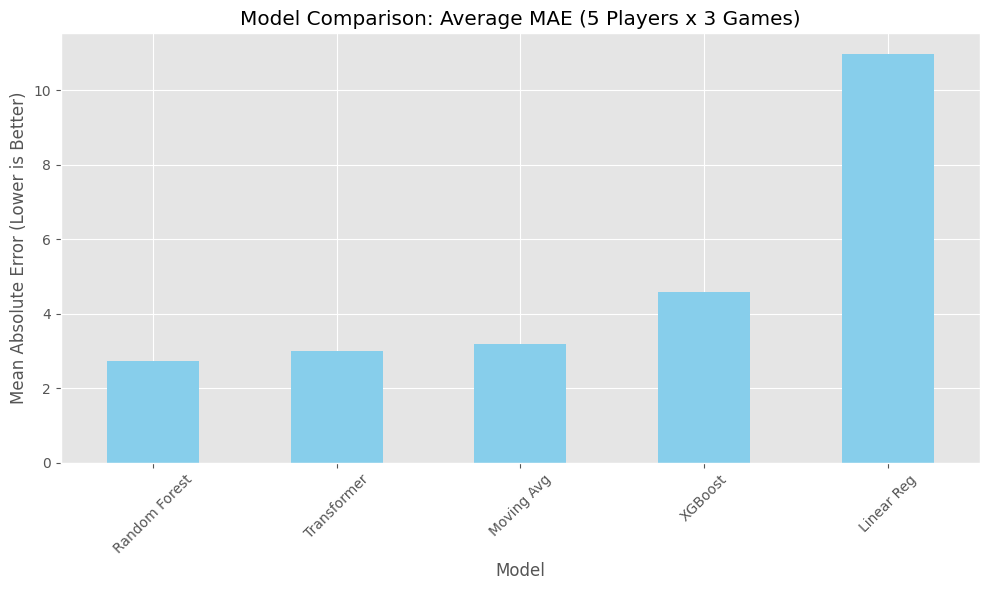

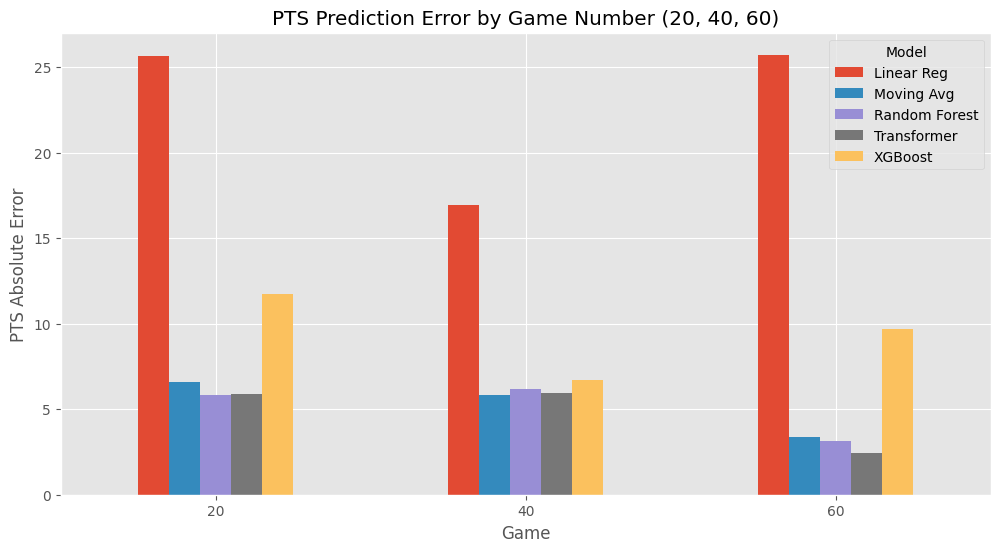

In [6]:
# --- Visualization ---
# Group by Model to see overall performance
avg_errors = results_df.groupby('Model')[['MAE', 'PTS_Err']].mean().sort_values('MAE')

print("Average MAE across all predictions:")
print(avg_errors)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
avg_errors['MAE'].plot(kind='bar', color='skyblue', ax=ax)
ax.set_title(f'Model Comparison: Average MAE (5 Players x 3 Games)')
ax.set_ylabel('Mean Absolute Error (Lower is Better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Game-Specific Breakdown
pivot = results_df.pivot_table(index='Game', columns='Model', values='PTS_Err', aggfunc='mean')
pivot.plot(kind='bar', figsize=(12, 6))
plt.title('PTS Prediction Error by Game Number (20, 40, 60)')
plt.ylabel('PTS Absolute Error')
plt.xticks(rotation=0)
plt.show()